In [1]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import geopandas as gpd 
from pyrocko import moment_tensor as mtm
from scipy import interpolate
from importlib import reload
from obspy.geodetics import kilometers2degrees

import sys
sys.path.append('/staff/quentin/Documents/Projects/2024_Venus_Detectability/Venus_Detectability')

import proba_modules as pm
import compute_network_shapes_CPUs as cns

In [2]:
root_dir = '/staff/quentin/Documents/Projects/2024_Venus_Detectability/'
file_atmos = f'{root_dir}Venus_Detectability/data/profile_VCD_for_scaling_pd.csv'
profile = pd.read_csv(file_atmos)
f_rho = interpolate.interp1d(profile.altitude/1e3, profile.rho, kind='quadratic')
f_t = interpolate.interp1d(profile.altitude/1e3, profile.t, kind='quadratic')
f_gamma = interpolate.interp1d(profile.altitude/1e3, profile.gamma, kind='quadratic')
f_c = interpolate.interp1d(profile.altitude/1e3, profile.c, kind='quadratic')

In [13]:
reload(cns)
reload(pm)

file_curve = f'{root_dir}/data/GF_Dirac_1Hz_all_wfreq.csv'
freq = [0.01, 0.1, 1.]
dayglow_scaling, nightglow_scaling, TL_new_v_airglow, TL_new_p_airglow = cns.get_airglow_SNR(file_curve, freq, file_atmos=file_atmos, file_nightglow=f'{root_dir}Venus_Detectability/data/VER_profile_scaled.csv', file_dayglow=f'{root_dir}Venus_Detectability/data/VER_profile_dayglow.csv', R0=6052000, photons_dayglow=3.5e5, alpha_dayglow=1e-5, photons_nightglow=2e4, beta=1., TL_new_v=None, TL_new_p=None, m0 = 5.)

100%|██████████| 3/3 [00:01<00:00,  1.87it/s]


In [22]:
reload(cns)

main_dir = '/staff/quentin/Documents/Projects/2024_Venus_Detectability/'
dir_GF = '/projects/restricted/infrasound/data/infrasound/2023_Venus_inversion/'
file_curve = f'{dir_GF}GF_Dirac_1Hz_combined.csv'
file_precomputed_scaling = f'{main_dir}data/data_airglow_scaling_from_seismo_median.csv'
boost_SNR=dict(dayglow=1, nightglow=1.)
model_subsurface = 'Cold100'
freq = [1e-2, 1e-1, 1.]

dict_scaling = dict(m0 = 6., file_precomputed_scaling=file_precomputed_scaling, R0=6052000, sigma_balloon=1e-2, boost_SNR=boost_SNR, photons_dayglow=3.5e5, alpha_dayglow=1e-5, photons_nightglow=2e4, beta=1., file_atmos=f'{main_dir}Venus_Detectability/data/profile_VCD_for_scaling_pd.csv', file_nightglow=f'{main_dir}Venus_Detectability/data/VER_profile_scaled.csv', file_dayglow=f'{main_dir}Venus_Detectability/data/VER_profile_dayglow.csv', model_subsurface=model_subsurface, return_df_scaling=True)
    
dayglow_scaling, nightglow_scaling, TL_new_v_airglow, TL_new_p_airglow = cns.get_airglow_scaling(file_curve, freq, **dict_scaling)

100%|██████████| 3/3 [00:01<00:00,  1.81it/s]


In [23]:
reload(pm)

dir_GF = '/projects/restricted/infrasound/data/infrasound/2023_Venus_inversion/'
file_curve = f'{dir_GF}GF_Dirac_1Hz_combined.csv'
alts = [45., 60.]

TL_new_p, TL_new_p_qmin, TL_new_p_qmax = dict(), dict(), dict()
for alt in alts:
    opt_TL = dict(
        rho0=f_rho(0.), 
        rhob=f_rho(alt), 
        cb=f_c(alt), 
        unknown='pressure', 
        model='Cold100'
    )
    TL_new_p[alt], TL_new_p_qmin[alt], TL_new_p_qmax[alt] = pm.get_TL_curves_precomputed(file_curve, **opt_TL)
    #dict_TL = dict(dist_min=100., rho0=f_rho(0.), rhob=f_rho(alt), cb=f_c(alt), use_savgol_filter=True, plot=False, scalar_moment=10e6, return_dataframe=False)
    #TL_new_p[alt], TL_new_p_qmin[alt], TL_new_p_qmax[alt] = pm.get_TL_curves(file_curve, freq, unknown='pressure', **dict_TL)

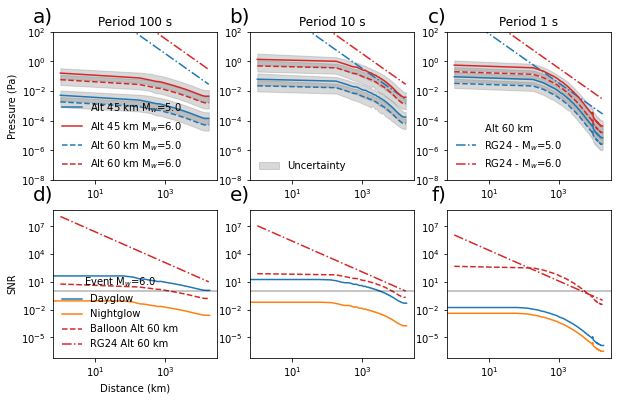

In [51]:
from matplotlib.ticker import LogLocator
import string

alphabet = string.ascii_lowercase

fig = plt.figure(figsize=(10,6))
grid = fig.add_gridspec(2, 3)

dists = np.linspace(1., 18e3, 100)
m0s = [5., 6.]
noise_level = 1e-2

delta_sigma = 3. # Stress drop (MPa)
Vs = 2500. # shear wave velocity (m/s)
n = 1.6 # Fall off rate

density_ratio = lambda alt: f_rho(alt)*f_c(alt)*np.sqrt(f_rho(0.)/f_rho(alt))
model_empirical = lambda mw, t, d, alt: density_ratio(alt)*(2*np.pi*1e-6)*t*10**(mw-3.3-1.66*np.log10(kilometers2degrees(d)))

colors_m0 = ['tab:blue', 'tab:red']
linestyle_alts = ['-', '--']
for iff, ff in enumerate(freq):
    opt_ax = dict()
    if iff > 0:
        opt_ax = dict(sharex=ax, sharey=ax)
    ax = fig.add_subplot(grid[0, iff], **opt_ax)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim([1e-8, 1e2])
    ax.set_title(f'Period {1./ff:.0f} s')
    ax.text(-0., 1.04, f'{alphabet[iff]})', fontsize=20., ha='right', va='bottom', transform=ax.transAxes)
    #ax.yaxis.set_minor_locator(LogLocator(base=10.0, subs='auto', numticks=12))
    #ax.xaxis.set_minor_locator(LogLocator(base=10.0, subs='auto', numticks=12))
    #ax.tick_params(axis='both', colors='white')
    #ax.tick_params(which='minor', length=4, color='gray')
    #ax.grid(True, which='both')
    
    for ialt, alt in enumerate(alts):
        TL_balloon = TL_new_p[alt][ff]
        TL_balloon_qmin = TL_new_p_qmin[alt][ff]
        TL_balloon_qmax = TL_new_p_qmax[alt][ff]
        for im0, m0 in enumerate(m0s):

            FC = pm.corner_frequency(m0, delta_sigma, Vs, Cs=0.32)
            COEFS_BRUNE = pm.brune_spectrum(ff, FC, n=n)
            #COEFS_BRUNE = 1.

            opt_label = dict()
            if iff == 0:
                opt_label = dict(label=f'Alt {alt:.0f} km M$_w$={m0}')
            opt_label_fill = dict()
            if iff == 1 and im0 == 0 and ialt == 0:
                opt_label_fill = dict(label=f'Uncertainty')
            ax.plot(dists, COEFS_BRUNE*TL_balloon(dists, m0), color=colors_m0[im0], ls=linestyle_alts[ialt], **opt_label)
            ax.fill_between(dists, COEFS_BRUNE*TL_balloon_qmin(dists, m0), COEFS_BRUNE*TL_balloon_qmax(dists, m0), color='grey', alpha=0.3, **opt_label_fill)
            if ialt == 0:
                opt_label_empirical = dict()
                if iff == 2:
                    opt_label_empirical = dict(label=f'RG24 - M$_w$={m0}')
                ax.plot(dists, model_empirical(m0, 1./ff, dists, alt), color=colors_m0[im0], ls='-.', **opt_label_empirical)
    
    dayglow_scaling_ff = dayglow_scaling.loc[dayglow_scaling.period==1./ff]
    nightglow_scaling_ff = nightglow_scaling.loc[nightglow_scaling.period==1./ff]
    opt_ax = dict(sharex=ax)
    if iff > 0:
        opt_ax = dict(sharex=ax, sharey=ax_airglow)
    ax_airglow = fig.add_subplot(grid[1, iff], **opt_ax)
    if iff == 0:
        opt_label = dict(label=f'Dayglow')
    ax_airglow.plot(dayglow_scaling_ff.distance, dayglow_scaling_ff.SNR, **opt_label)
    if iff == 0:
        opt_label = dict(label=f'Nightglow')
    ax_airglow.plot(nightglow_scaling_ff.distance, nightglow_scaling_ff.SNR, **opt_label)
    if iff == 0:
        opt_label = dict(label=f'Balloon Alt {alt:.0f} km')
    ax_airglow.plot(dists, TL_balloon(dists, m0)/noise_level, color=colors_m0[im0], ls=linestyle_alts[ialt], **opt_label)
    if iff == 0:
        opt_label = dict(label=f'RG24 Alt {alt:.0f} km')
    ax_airglow.plot(dists, model_empirical(m0, 1./ff, dists, alt)/noise_level, color=colors_m0[im0], ls='-.', **opt_label)
    ax_airglow.set_xscale('log')
    ax_airglow.set_yscale('log')
    ax_airglow.axhline(1., color='black', alpha=0.3)
    ax_airglow.text(-0., 1.04, f'{alphabet[iff+3]})', fontsize=20., ha='right', va='bottom', transform=ax_airglow.transAxes)

    if iff == 0:
        ax.legend(frameon=False)
        ax.set_ylabel(f'Pressure (Pa)')
        ax_airglow.legend(title=f'Event M$_w$={m0}', frameon=False, loc='lower left')
        ax_airglow.set_ylabel(f'SNR')
        ax_airglow.set_xlabel('Distance (km)')
    elif iff == 1:
        ax.legend(frameon=False)
    elif iff == 2:
        ax.legend(frameon=False, loc='lower left', title=f'Alt {alts[ialt]:.0f} km')

plt.savefig('./figures/Figure_amplitudes.pdf')

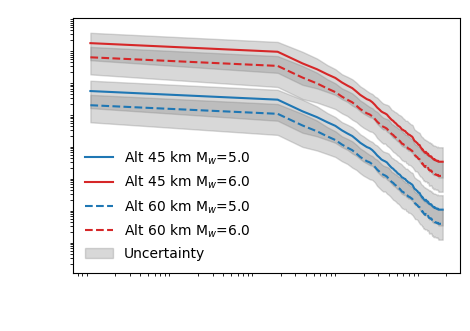

In [70]:
fig = plt.figure(figsize=(5,3.5))
grid = fig.add_gridspec(1, 1)

iff = 2
ff = freq[iff]

ax = fig.add_subplot(grid[0, 0],)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([1e-6, 1e2])
#ax.set_title(f'Period {1./ff:.0f} s')
ax.set_xlabel('Distance (km)', color='white')
ax.set_ylabel('Pressure (Pa)', color='white')

for ialt, alt in enumerate(alts):

    TL_balloon = TL_new_p[alt][ff]
    TL_balloon_qmin = TL_new_p_qmin[alt][ff]
    TL_balloon_qmax = TL_new_p_qmax[alt][ff]
    for im0, m0 in enumerate(m0s):
        opt_label = dict(label=f'Alt {alt:.0f} km M$_w$={m0}')
        opt_label_fill = dict()
        if ialt == len(alts)-1 and im0 == len(m0s)-1:
            opt_label_fill = dict(label=f'Uncertainty')
        ax.plot(dists, TL_balloon(dists, m0), color=colors_m0[im0], ls=linestyle_alts[ialt], **opt_label)
        ax.fill_between(dists, TL_balloon_qmin(dists, m0), TL_balloon_qmax(dists, m0), color='grey', alpha=0.3, **opt_label_fill)

rect = plt.Rectangle(
    (0, 0), 1, 1,
    transform=ax.transAxes,  # Use axes coordinates
    color='white',
    zorder=-1,  # Place it below all other elements
)
ax.add_patch(rect)
ax.tick_params(axis='both', colors='white')

ax.legend(frameon=False)
fig.patch.set_alpha(0)
fig.subplots_adjust(bottom=0.15)
fig.savefig('./figures/Figure_2_amplitudes_AGU.png', transparent=True)

In [54]:
volcanoes = pd.read_csv('./Venus_Detectability/data/volcanoes/05_large_greaterthan100.csv', header=[0])
volcanoes.loc[volcanoes.Area_Geo == volcanoes.Area_Geo.max()]

,OID_,Lat_Center,Lon_Center,Area_Geo,AR,Height_km,Diam_Geo,Length_km,Width_km
95,95,8.687137,-52.476376,634913.777744,0.67661,1.981125,863.555,1030.12,696.99
